In [1]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
import tensorflow as tf
from nn_models import TextCNN, TextCNN_field_aware, TextRNN, TextRNN_field_aware, TextRNN_attention
import data_helpers
import os
import time
import datetime
import pickle
import copy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_curve, roc_curve

/Users/zyzzhaoyuzhe/virtualenvs/nlp3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
ORDERED_NAMES = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

--------
# Read data

In [4]:
# Load
df_processed = pickle.load(open('Data/DataFrame_processed.p', 'rb'))

---
# Data Prep

In [5]:
TO_PREDICT = 'Past'
FIELDS = [
    'history',
    'findings',
    'comparison',
    'impression',
#     'Grade',
#     'Present',
#     'Past'
]

# df_filtered = df_processed[~df_processed[TO_PREDICT].isnull() & (df_processed[TO_PREDICT] != 0)].sample(frac=1, random_state=1)
df_filtered = df_processed[~df_processed[TO_PREDICT].isnull()].sample(frac=1, random_state=1)
df_filtered = df_filtered[[TO_PREDICT] + FIELDS]

df_train = df_filtered.iloc[:1220]
y_train = np.array(df_train[TO_PREDICT].astype(int))
enc = LabelEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train)

df_test = df_filtered.iloc[1220:]
y_test = np.array(df_test[TO_PREDICT].astype(int))
y_test = enc.transform(y_test)

print(df_train.shape)
print(df_test.shape)
df_filtered[TO_PREDICT].value_counts()

(1220, 5)
(307, 5)


-1    1172
 1     355
Name: Past, dtype: int64

---
---
# Neural Nets

**Data Prep**

In [6]:
df_train.columns

Index(['Past', 'history', 'findings', 'comparison', 'impression'], dtype='object')

In [7]:
maxlen = [100,
          125,
          50,
          100]

In [8]:
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
x_train = np.array(utils.Text_Proc.encode_texts(x_train_text, word2idx, maxlen=sum(maxlen)))

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train[:, None])

x_dev_text = utils.Dataframe_Proc.df2text(df_test, df_test.columns[1:])
x_dev = np.array(utils.Text_Proc.encode_texts(x_dev_text, word2idx, maxlen=x_train.shape[1]))

y_dev = enc.transform(y_test[:, None])

/Users/zyzzhaoyuzhe/virtualenvs/nlp3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
x_train.shape

(1220, 375)

### NN Models

In [50]:
# Clear flags
if FLAGS._flags():
    for key in [key for key in FLAGS._flags().keys()]:
        FLAGS.__delattr__(key)

# Both CNN and RNN
tf.flags.DEFINE_integer("embedding_dim", 64, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.1, "L2 regularization lambda (default: 0.0)")

# CNN parameter
tf.flags.DEFINE_string("filter_sizes", "3,4", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")

# RNN parameter
tf.flags.DEFINE_integer('hidden_size', 64, 'Hidden size of LSTM')
tf.flags.DEFINE_integer('num_layers', 1, 'Number of LSTM layers')

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
tf.flags.DEFINE_integer("num_epochs", 100, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
tf.flags.DEFINE_integer("log_every", 10, "Logs model on dev set after this many steps (default: 100)")

# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

# Fix Bugs 
tf.app.flags.DEFINE_string('f', '', 'kernel')

FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


Parameters:
ALLOW_SOFT_PLACEMENT=<absl.flags._flag.BooleanFlag object at 0x136bda3c8>
BATCH_SIZE=<absl.flags._flag.Flag object at 0x12d8d9f98>
CHECKPOINT_EVERY=<absl.flags._flag.Flag object at 0x12d8d7a58>
DROPOUT_KEEP_PROB=<absl.flags._flag.Flag object at 0x136bdd160>
EMBEDDING_DIM=<absl.flags._flag.Flag object at 0x136bddda0>
EVALUATE_EVERY=<absl.flags._flag.Flag object at 0x12d8d74e0>
F=<absl.flags._flag.Flag object at 0x12f18e9e8>
FILTER_SIZES=<absl.flags._flag.Flag object at 0x136bddc88>
HIDDEN_SIZE=<absl.flags._flag.Flag object at 0x12e092a90>
L2_REG_LAMBDA=<absl.flags._flag.Flag object at 0x136bdd9e8>
LEARNING_RATE=<absl.flags._flag.Flag object at 0x12d8d9828>
LOG_DEVICE_PLACEMENT=<absl.flags._flag.BooleanFlag object at 0x119d9bef0>
LOG_EVERY=<absl.flags._flag.Flag object at 0x136bdad68>
NUM_CHECKPOINTS=<absl.flags._flag.Flag object at 0x12d8d7a90>
NUM_EPOCHS=<absl.flags._flag.Flag object at 0x12d8d9080>
NUM_FILTERS=<absl.flags._flag.Flag object at 0x12e0922b0>
NUM_LAYERS=<absl

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        
        model = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(word2idx),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextCNN_field_aware(sequence_lengths=maxlen,
#                                     num_classes=y_train.shape[1],
#                                     vocab_size=len(word2idx),
#                                     embedding_size=FLAGS.embedding_dim,
#                                     filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
#                                     num_filters=FLAGS.num_filters,
#                                     l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_field_aware(sequence_lengths=maxlen,
#                                     num_classes=y_train.shape[1],
#                                     vocab_size=len(word2idx),
#                                     embedding_size=FLAGS.embedding_dim,
#                                     hidden_size=FLAGS.hidden_size,
#                                     num_layers=FLAGS.num_layers,
#                                     l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_attention(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)


        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        # optimizer = tf.train.GradientDescentOptimizer(1e-3)
        optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
        grads_and_vars = optimizer.compute_gradients(model.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))

        if 'CNN' in model.__class__.__name__:
            name = "CNN_{}_{}_".format(FLAGS.embedding_dim, FLAGS.num_filters)
        elif 'RNN' in model.__class__.__name__:
            name = "RNN_{}_{}_{}_".format(FLAGS.embedding_dim, FLAGS.hidden_size, FLAGS.num_layers)


        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", name + timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", model.loss)
        acc_summary = tf.summary.scalar("accuracy", model.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        # vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: FLAGS.dropout_keep_prob,
                model.batch_size: len(x_batch)
            }

            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            if step % FLAGS.log_every == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: 1.0,
                model.batch_size: len(x_batch)
            }

            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)

            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

        #
        feed_dict = {
            model.input_x: x_dev,
            model.input_y: y_dev,
            model.dropout_keep_prob: 1.0,
            model.batch_size: len(x_dev)
        }
        y_dev_pred = sess.run([model.predictions], feed_dict=feed_dict)
        y_dev_prob = sess.run([tf.math.exp(model.logits)], feed_dict=feed_dict)
#         y_dev_pred, alpha = sess.run([model.predictions, model.alpha], feed_dict=feed_dict)

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 

2019-03-13T23:16:00.196600: step 820, loss 0.902088, acc 0.75
2019-03-13T23:16:02.255465: step 830, loss 0.198542, acc 0.921875
2019-03-13T23:16:04.392791: step 840, loss 0.176717, acc 1
2019-03-13T23:16:06.675415: step 850, loss 0.301644, acc 0.921875
2019-03-13T23:16:08.624880: step 860, loss 0.105039, acc 1
2019-03-13T23:16:11.167899: step 870, loss 0.216011, acc 0.953125
2019-03-13T23:16:13.411588: step 880, loss 0.229954, acc 1
2019-03-13T23:16:15.958366: step 890, loss 0.280582, acc 0.890625
2019-03-13T23:16:17.863827: step 900, loss 0.0742189, acc 1

Evaluation:
2019-03-13T23:16:18.169473: step 900, loss 0.324054, acc 0.899023

Saved model checkpoint to /Users/zyzzhaoyuzhe/Documents/Med-NLP/runs/CNN_64_128_1552533193/checkpoints/model-900

2019-03-13T23:16:20.284482: step 910, loss 0.247719, acc 0.953125
2019-03-13T23:16:22.107352: step 920, loss 0.0954444, acc 1
2019-03-13T23:16:24.169602: step 930, loss 0.306952, acc 0.921875
2019-03-13T23:16:26.002276: step 940, loss 0.597108

In [47]:
# PR Curve
pr_curves = []  # reset 

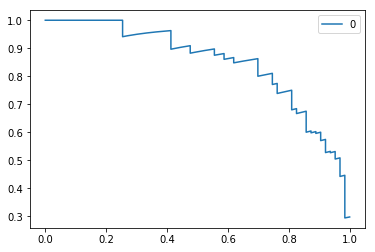

In [48]:
# PR Curve
pr_curves.append(precision_recall_curve(y_test, y_dev_prob[0][:, 1]))
for pr_curve in pr_curves:
    plt.plot(pr_curve[1], pr_curve[0])
plt.legend(range(len(pr_curves)))

In [31]:
# ROC curve
rocs = []  # reset 

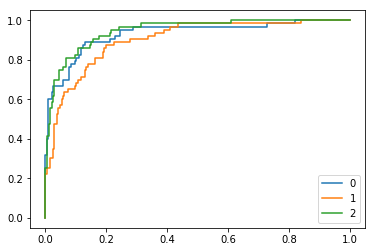

In [49]:
# ROC Curve
rocs.append(roc_curve(y_test, y_dev_prob[0][:, 1]))
for roc in rocs:
    plt.plot(roc[0], roc[1])
plt.legend(range(len(rocs)))

In [17]:
utils.my_classification_report(y_test, y_dev_pred[0])

/Users/zyzzhaoyuzhe/Documents/Med-NLP/utils.py:507: RuntimeWarning: invalid value encountered in long_scalars
  precision = CM.iloc[1, 1] / CM.iloc[:, 1].sum()


sensitivity    0.000000
specificity    1.000000
precision           NaN
NPV            0.794788
accuracy       0.794788
dtype: float64

In [ ]:
model = "TextRNN_field_aware"
output = output_report(y_test, y_dev_pred[0])
output.to_csv("CI/" + model +'.csv', header=False)